### Load Dataset of 20 classes from cifar 100

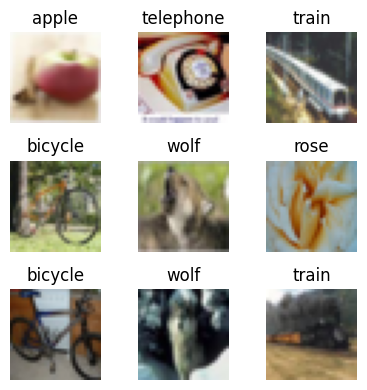

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Loading CIFAR-100 with fine labels
(trainX_all, trainY_all), (testX_all, testY_all) = cifar100.load_data(label_mode='fine')

# Defining 20 selected class names
selected_classes = [
    'beaver', 'dolphin', 'otter', 'seal', 'whale',
    'bear', 'tiger', 'lion', 'wolf', 'fox',
    'apple', 'orange', 'pear', 'rose', 'tulip',
    'bicycle', 'motorcycle', 'train', 'rocket', 'telephone'
]

# Full CIFAR-100 fine label names (in order)
all_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

# Geting indices for selected classes
selected_indices = [all_fine_labels.index(cls) for cls in selected_classes]

# Filter function
def filter_data(X, Y, class_indices):
    mask = np.isin(Y.flatten(), class_indices)
    X_filtered = X[mask]
    Y_filtered = Y[mask]
    label_map = {orig: new for new, orig in enumerate(class_indices)}
    Y_remapped = np.array([label_map[y[0]] for y in Y_filtered]).reshape(-1, 1)
    return X_filtered, Y_remapped

# Applying filtering to training and test sets
trainX_filtered, trainY_filtered = filter_data(trainX_all, trainY_all, selected_indices)
testX_filtered, testY_filtered = filter_data(testX_all, testY_all, selected_indices)

#  Display function
def display_img(img_set, label_set, class_names, n=9):
    plt.figure(figsize=(4, 4))
    for i in range(n):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_set[i])
        plt.title(class_names[label_set[i][0]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Showing first 9 filtered images
display_img(trainX_filtered, trainY_filtered, selected_classes)


### Pre Process the data

In [ ]:
from tensorflow.image import resize

# Normalize to [0, 1]
trainX_filtered = trainX_filtered.astype('float32') / 255.0
testX_filtered = testX_filtered.astype('float32') / 255.0

# Resize to 96x96x3
trainX_filtered = resize(trainX_filtered, (96, 96))
testX_filtered = resize(testX_filtered, (96, 96))

# One-hot encode labels (20 classes)
trainY_filtered = to_categorical(trainY_filtered, num_classes=20)
testY_filtered = to_categorical(testY_filtered, num_classes=20)

# Final training data
trainX = trainX_filtered
trainY = trainY_filtered
testX = testX_filtered
testY = testY_filtered

# Print data shapes and types
print(f"trainX.shape: {trainX.shape}, testX.shape: {testX.shape}")
print(f"trainX.dtype: {trainX.dtype}, testX.dtype: {testX.dtype}")
print(f"trainY.shape: {trainY.shape}, testY.shape: {testY.shape}")
print(f"trainY.dtype: {trainY.dtype}, testY.dtype: {testY.dtype}")

# Check sample labels
print("Sample trainY (one-hot encoded):")
print(trainY[:5])


trainX.shape: (10000, 96, 96, 3), testX.shape: (2000, 96, 96, 3)
trainX.dtype: <dtype: 'float32'>, testX.dtype: <dtype: 'float32'>
trainY.shape: (10000, 20), testY.shape: (2000, 20)
trainY.dtype: float64, testY.dtype: float64
Sample trainY (one-hot encoded):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### 1. MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Loading pre-trained MobileNet with input shape 96x96x3
mobilenet = MobileNet(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze all layers in the MobileNet backbone
for layer in mobilenet.layers:
    layer.trainable = False

# Build classification head for 20 classes
inputs_mobilenet = mobilenet.input
x = mobilenet.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs_final = Dense(20, activation='tanh', name='OutputLayer')(x)

# Create the model
model = Model(inputs=inputs_mobilenet, outputs=outputs_final, name='MobileNet_CIFAR100_20Classes')

# Print model summary
model.summary()


<ipython-input-8-7b4b642718c8>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNet(input_shape=(96, 96, 3), include_top=False, weights='imagenet')


Model: "MobileNet_CIFAR100_20Classes"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 48, 48, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 48, 48, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 48, 48, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 24, 24, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 24, 24, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 24, 24, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 24, 24, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,819,668 (18.39 MB)

 Trainable params: 1,587,732 (6.06 MB)

 Non-trainable params: 3,231,936 (12.33 MB)

### Transfer Learning

In [ ]:
import tensorflow as tf

# Compile the model for Transfer Learning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train only the classification head
history_transfer_learning = model.fit(
    trainX, trainY,
    batch_size=64,
    validation_split=0.1,
    epochs=10,
    verbose=1
)

# Evaluate on the test set
t_loss, t_acc = model.evaluate(testX, testY, verbose=0)
print(f"📊 Transfer Learning Test Accuracy: {t_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.0826 - loss: 7.7087 - val_accuracy: 0.0950 - val_loss: 8.5265
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1134 - loss: 8.3358 - val_accuracy: 0.0770 - val_loss: 8.6268
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0889 - loss: 8.3904 - val_accuracy: 0.1230 - val_loss: 9.0385
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1151 - loss: 8.4015 - val_accuracy: 0.0480 - val_loss: 8.6668
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0973 - loss: 8.1957 - val_accuracy: 0.1120 - val_loss: 7.9198
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1193 - loss: 8.2524 - val_accuracy: 0.0820 - val_loss: 7.9775
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1156 - loss: 8.3542 - val_accuracy: 0.1220 - val_loss: 9.3679
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1159 - loss: 8.4659 - val_acc

### Finetuning the model

In [ ]:
import tensorflow as tf

#  Unfreeze the last 40 layers of MobileNet for fine-tuning
for layer in model.layers[-40:]:
    layer.trainable = True

#  Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#  Fine-tune the model
history_finetune = model.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=15,
    batch_size=64,
    verbose=1
)

#  Evaluate the model on the test set
finetune_loss, finetune_accuracy = model.evaluate(testX, testY, verbose=0)
print(f"📊 Fine-Tuning Test Accuracy: {finetune_accuracy:.4f}")


Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.0725 - loss: 8.1196 - val_accuracy: 0.0770 - val_loss: 7.3258
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.0672 - loss: 8.2475 - val_accuracy: 0.0630 - val_loss: 8.0207
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0522 - loss: 8.0361 - val_accuracy: 0.0630 - val_loss: 7.8899
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0548 - loss: 7.7049 - val_accuracy: 0.0460 - val_loss: 8.0285
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.0596 - loss: 7.9411 - val_accuracy: 0.0540 - val_loss: 7.5984
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0542 - loss: 7.9098 - val_accuracy: 0.0500 - val_loss: 7.7107
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.0516 - loss: 7.7183 - val_accuracy: 0.0450 - val_loss: 7.1413
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0481 - loss: 7.6542 - val_acc

### 2. VGG 16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Loading pre-trained VGG16 model, excluding the top classification layers
vgg_base = VGG16(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze all layers in VGG16
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom classification head
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(20, activation='tanh', name='OutputLayer')(x)

# Final model
model_vgg16 = Model(inputs=vgg_base.input, outputs=outputs, name='VGG16_CIFAR100_20Classes')
model_vgg16.summary()


Model: "VGG16_CIFAR100_20Classes"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       524,80

 Total params: 15,781,204 (60.20 MB)

 Trainable params: 1,063,444 (4.06 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

In [ ]:
# Compile the model for transfer learning
model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train only the new head
history_vgg_transfer = model_vgg16.fit(
    trainX, trainY,
    batch_size=64,
    validation_split=0.1,
    epochs=10,
    verbose=1
)

# Evaluate
vgg_transfer_loss, vgg_transfer_acc = model_vgg16.evaluate(testX, testY, verbose=0)
print(f"📊 VGG16 Transfer Learning Test Accuracy: {vgg_transfer_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.0667 - loss: 7.7506 - val_accuracy: 0.1240 - val_loss: 8.8391
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.1133 - loss: 8.3473 - val_accuracy: 0.1000 - val_loss: 8.4937
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.0742 - loss: 8.1676 - val_accuracy: 0.1370 - val_loss: 8.6513
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.0900 - loss: 8.2779 - val_accuracy: 0.1130 - val_loss: 8.2876
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.0907 - loss: 8.4140 - val_accuracy: 0.0990 - val_loss: 8.2983
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.0973 - loss: 8.1132 - val_accuracy: 0.0860 - val_loss: 8.2068
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.0873 - loss: 8.2748 - val_accuracy: 0.0850 - val_loss: 8.0027
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.0813 - loss: 8.4434 -

In [ ]:
# Unfreeze last few layers of VGG16
for layer in model_vgg16.layers[-40:]:
    layer.trainable = True

# Recompile
model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_vgg_finetune = model_vgg16.fit(
    trainX, trainY,
    batch_size=64,
    validation_split=0.1,
    epochs=10,
    verbose=1
)

# Evaluate fine-tuned model
vgg_finetune_loss, vgg_finetune_acc = model_vgg16.evaluate(testX, testY, verbose=0)
print(f"📊 VGG16 Fine-Tuning Test Accuracy: {vgg_finetune_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 258ms/step - accuracy: 0.0571 - loss: 7.6103 - val_accuracy: 0.0560 - val_loss: 6.7631
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.0523 - loss: 7.6633 - val_accuracy: 0.0580 - val_loss: 8.2868
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.0474 - loss: 7.6627 - val_accuracy: 0.0460 - val_loss: 8.1882
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - accuracy: 0.0470 - loss: 7.7737 - val_accuracy: 0.0460 - val_loss: 7.2702
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.0518 - loss: 7.6291 - val_accuracy: 0.0460 - val_loss: 7.7234
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.0545 - loss: 7.7302 - val_accuracy: 0.0380 - val_loss: 7.1865
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.0524 - loss: 7.7101 - val_accuracy: 0.0460 - val_loss: 7.6325
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - accuracy: 0.0502 - loss: 7

### 3. ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load pre-trained ResNet50 without top layers
resnet_base = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze base model
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom head
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(20, activation='tanh')(x)

model_resnet = Model(inputs=resnet_base.input, outputs=outputs, name='ResNet50_CIFAR100_20')
model_resnet.summary()


Model: "ResNet50_CIFAR100_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 26,227,092 (100.05 MB)

 Trainable params: 2,636,308 (10.06 MB)

 Non-trainable params: 23,590,784 (89.99 MB)

In [ ]:
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet_transfer = model_resnet.fit(trainX, trainY, batch_size=64,
                                           validation_split=0.1, epochs=10, verbose=1)

resnet_transfer_loss, resnet_transfer_acc = model_resnet.evaluate(testX, testY, verbose=0)
print(f"📊 ResNet50 Transfer Learning Accuracy: {resnet_transfer_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.0504 - loss: 7.4019 - val_accuracy: 0.0610 - val_loss: 8.1334
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.0475 - loss: 7.7048 - val_accuracy: 0.0520 - val_loss: 7.9283
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.0530 - loss: 7.3242 - val_accuracy: 0.0590 - val_loss: 7.7770
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.0539 - loss: 7.7594 - val_accuracy: 0.0670 - val_loss: 7.6143
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.0551 - loss: 7.6890 - val_accuracy: 0.0600 - val_loss: 7.8792
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.0521 - loss: 7.6813 - val_accuracy: 0.0480 - val_loss: 7.4215
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.0587 - loss: 7.4804 - val_accuracy: 0.0580 - val_loss: 7.9191
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.0497 - loss: 7.9402 - v

In [ ]:
for layer in model_resnet.layers[-40:]:
    layer.trainable = True

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet_finetune = model_resnet.fit(trainX, trainY, batch_size=64,
                                           validation_split=0.1, epochs=10, verbose=1)

resnet_finetune_loss, resnet_finetune_acc = model_resnet.evaluate(testX, testY, verbose=0)
print(f"📊 ResNet50 Fine-Tuning Accuracy: {resnet_finetune_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 171ms/step - accuracy: 0.0428 - loss: 7.5830 - val_accuracy: 0.0460 - val_loss: 8.0020
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.0539 - loss: 7.6619 - val_accuracy: 0.0440 - val_loss: 7.3091
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.0424 - loss: 7.6476 - val_accuracy: 0.0530 - val_loss: 8.1209
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.0510 - loss: 7.7035 - val_accuracy: 0.0400 - val_loss: 7.9623
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.0535 - loss: nan - val_accuracy: 0.0670 - val_loss: nan
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.0472 - loss: nan - val_accuracy: 0.0670 - val_loss: nan
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.0501 - loss: nan - val_accuracy: 0.0670 - val_loss: nan
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.0480 - loss: nan - val_accuracy: 0.0670 -

### 4. InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

inception_base = InceptionV3(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

for layer in inception_base.layers:
    layer.trainable = False

x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(20, activation='tanh')(x)

model_inception = Model(inputs=inception_base.input, outputs=outputs, name='InceptionV3_CIFAR100_20')
model_inception.summary()


Model: "InceptionV3_CIFAR100_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 47, 47,    │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 45, 45,    │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 45, 45,    │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 22, 22,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 22, 22,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 20, 20,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 20, 20,    │          0 │ batch_normalizat

 Total params: 24,442,164 (93.24 MB)

 Trainable params: 2,636,308 (10.06 MB)

 Non-trainable params: 21,805,856 (83.18 MB)

In [ ]:
model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='categorical_crossentropy', metrics=['accuracy'])

history_inception_transfer = model_inception.fit(trainX, trainY, batch_size=64,
                                                 validation_split=0.1, epochs=10, verbose=1)

inception_transfer_loss, inception_transfer_acc = model_inception.evaluate(testX, testY, verbose=0)
print(f"📊 InceptionV3 Transfer Learning Accuracy: {inception_transfer_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 37s 160ms/step - accuracy: 0.0625 - loss: 7.7283 - val_accuracy: 0.0940 - val_loss: 7.3875
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0835 - loss: 7.8523 - val_accuracy: 0.1110 - val_loss: 7.8623
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1047 - loss: 8.0774 - val_accuracy: 0.1020 - val_loss: 8.4330
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.0895 - loss: 8.2862 - val_accuracy: 0.0890 - val_loss: 7.4253
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.0881 - loss: 8.0807 - val_accuracy: 0.0960 - val_loss: 7.9014
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0788 - loss: 8.0228 - val_accuracy: 0.1050 - val_loss: 7.8146
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.0825 - loss: 7.9736 - val_accuracy: 0.0910 - val_loss: 8.0079
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.0975 - loss: 7.9238 - val_ac

In [ ]:
for layer in model_inception.layers[-40:]:
    layer.trainable = True

model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='categorical_crossentropy', metrics=['accuracy'])

history_inception_finetune = model_inception.fit(trainX, trainY, batch_size=64,
                                                 validation_split=0.1, epochs=10, verbose=1)

inception_finetune_loss, inception_finetune_acc = model_inception.evaluate(testX, testY, verbose=0)
print(f"📊 InceptionV3 Fine-Tuning Accuracy: {inception_finetune_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 171ms/step - accuracy: 0.0810 - loss: 8.2022 - val_accuracy: 0.0440 - val_loss: 7.7335
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.0575 - loss: 8.1311 - val_accuracy: 0.0580 - val_loss: 7.8402
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.0593 - loss: 8.0377 - val_accuracy: 0.0420 - val_loss: 8.2534
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0512 - loss: nan - val_accuracy: 0.0670 - val_loss: nan
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.0450 - loss: nan - val_accuracy: 0.0670 - val_loss: nan
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0495 - loss: nan - val_accuracy: 0.0670 - val_loss: nan
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.0466 - loss: nan - val_accuracy: 0.0670 - val_loss: nan
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0430 - loss: nan - val_accuracy: 0.0670 - val_loss

### 5. InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Loading the InceptionResNetV2 base
base_model = InceptionResNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='tanh')(x)  # 20-class output

model_incepresnet = Model(inputs=base_model.input, outputs=predictions)
model_incepresnet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 47, 47,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 47, 47,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 20,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 20, 20,    │          0 │ batch_normalizat

 Total params: 56,451,828 (215.35 MB)

 Trainable params: 2,112,020 (8.06 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

In [ ]:
model_incepresnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = model_incepresnet.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

transfer_loss, transfer_acc = model_incepresnet.evaluate(testX, testY, verbose=0)
print(f"📊 InceptionResNetV2 Transfer Learning Accuracy: {transfer_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 74s 317ms/step - accuracy: 0.0721 - loss: 7.4949 - val_accuracy: 0.0960 - val_loss: 8.9517
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.1051 - loss: 8.1189 - val_accuracy: 0.0690 - val_loss: 8.1855
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.0699 - loss: 8.0840 - val_accuracy: 0.0980 - val_loss: 8.6326
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.0748 - loss: 7.9934 - val_accuracy: 0.0750 - val_loss: 7.6838
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.0825 - loss: 7.7723 - val_accuracy: 0.1160 - val_loss: 8.5436
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.0991 - loss: 8.0326 - val_accuracy: 0.1310 - val_loss: 7.8568
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.1107 - loss: 8.1709 - val_accuracy: 0.1590 - val_loss: 8.7392
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.1214 - loss: 8.1783 - v

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Unfreeze top layers
for layer in model_incepresnet.layers[-40:]:
    layer.trainable = True

# Recompile
model_incepresnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to improve fine-tuning stability
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Fine-tune
history_finetune = model_incepresnet.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

finetune_loss, finetune_acc = model_incepresnet.evaluate(testX, testY, verbose=0)
print(f"📊 InceptionResNetV2 Fine-Tuning Accuracy: {finetune_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 94s 374ms/step - accuracy: 0.0565 - loss: 7.5876 - val_accuracy: 0.0320 - val_loss: 7.5994 - learning_rate: 1.0000e-05
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.0544 - loss: 7.4808 - val_accuracy: 0.0270 - val_loss: 7.5706 - learning_rate: 1.0000e-05
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.0513 - loss: 7.4229 - val_accuracy: 0.0350 - val_loss: 7.4794 - learning_rate: 1.0000e-05
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.0487 - loss: 7.3541 - val_accuracy: 0.0380 - val_loss: 7.6055 - learning_rate: 1.0000e-05
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.0491 - loss: 7.4584 - val_accuracy: 0.0370 - val_loss: 7.4007 - learning_rate: 1.0000e-05
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.0456 - loss: 7.5347 - val_accuracy: 0.0350 - val_loss: 7.3894 - learning_rate: 1.0000e-05
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step -

### 6. MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='tanh')(x)  # 20 classes

model_mobilenetv2 = Model(inputs=base_model.input, outputs=predictions)
model_mobilenetv2.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 4,110,932 (15.68 MB)

 Trainable params: 1,849,876 (7.06 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [ ]:
model_mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = model_mobilenetv2.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

transfer_loss, transfer_acc = model_mobilenetv2.evaluate(testX, testY, verbose=0)
print(f"📊 MobileNetV2 Transfer Learning Accuracy: {transfer_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.0524 - loss: 7.8196 - val_accuracy: 0.0460 - val_loss: 8.7405
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0948 - loss: 8.3093 - val_accuracy: 0.0720 - val_loss: 8.5427
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1039 - loss: 8.6687 - val_accuracy: 0.0880 - val_loss: 8.5719
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1186 - loss: 8.7805 - val_accuracy: 0.1340 - val_loss: 8.5633
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1238 - loss: 8.6384 - val_accuracy: 0.1730 - val_loss: 8.8413
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1406 - loss: 8.4768 - val_accuracy: 0.1490 - val_loss: 8.5098
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1478 - loss: 8.8380 - val_accuracy: 0.1010 - val_loss: 8.3934
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1088 - loss: 8.7823 - val_acc

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Unfreeze last 40 layers for fine-tuning
for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

# Recompile
model_mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

history_finetune = model_mobilenetv2.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

finetune_loss, finetune_acc = model_mobilenetv2.evaluate(testX, testY, verbose=0)
print(f"📊 MobileNetV2 Fine-Tuning Accuracy: {finetune_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.0915 - loss: 8.2978 - val_accuracy: 0.0790 - val_loss: 8.1442 - learning_rate: 1.0000e-05
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.0865 - loss: 8.5300 - val_accuracy: 0.0610 - val_loss: 7.6101 - learning_rate: 1.0000e-05
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.0969 - loss: 8.2602 - val_accuracy: 0.0570 - val_loss: 7.7430 - learning_rate: 1.0000e-05
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0908 - loss: 8.3169
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0908 - loss: 8.3170 - val_accuracy: 0.0600 - val_loss: 7.6991 - learning_rate: 1.0000e-05
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.0944 - loss: 8.2407 - val_accuracy: 0.0690 - val_loss: 7.7345 - learning_rate: 5.0000e-06
Epoch 6/10
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accur

### 7. DenseNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load DenseNet121 base model
base_model = DenseNet121(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='tanh')(x)

model_densenet = Model(inputs=base_model.input, outputs=predictions)
model_densenet.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 102, 102,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 24, 24,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 24, 24,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 24, 24,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 24, 24,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 24, 24,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 24, 24,    │     12,288 │ conv2_block2_0_r

 Total params: 8,628,308 (32.91 MB)

 Trainable params: 1,587,732 (6.06 MB)

 Non-trainable params: 7,040,576 (26.86 MB)

In [ ]:
model_densenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = model_densenet.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

transfer_loss, transfer_acc = model_densenet.evaluate(testX, testY, verbose=0)
print(f"📊 DenseNet121 Transfer Learning Accuracy: {transfer_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 63s 256ms/step - accuracy: 0.1026 - loss: 8.1673 - val_accuracy: 0.1040 - val_loss: 8.1541
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.1099 - loss: 8.3478 - val_accuracy: 0.1060 - val_loss: 8.4848
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.0911 - loss: 8.3312 - val_accuracy: 0.0690 - val_loss: 7.8576
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.0958 - loss: 8.2883 - val_accuracy: 0.0800 - val_loss: 8.3711
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.0955 - loss: 8.3235 - val_accuracy: 0.0980 - val_loss: 8.9296
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.1142 - loss: 8.3047 - val_accuracy: 0.1010 - val_loss: 8.5215
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.1207 - loss: 8.4209 - val_accuracy: 0.1460 - val_loss: 9.1124
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.1074 - loss: 8.6571 - v

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Unfreeze the last 40 layers of the base model
for layer in model_densenet.layers[-40:]:
    layer.trainable = True

# Recompile
model_densenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

history_finetune = model_densenet.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

finetune_loss, finetune_acc = model_densenet.evaluate(testX, testY, verbose=0)
print(f"📊 DenseNet121 Fine-Tuning Accuracy: {finetune_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 78s 298ms/step - accuracy: 0.1001 - loss: 8.4465 - val_accuracy: 0.0990 - val_loss: 8.7123 - learning_rate: 1.0000e-05
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.0904 - loss: 8.4776 - val_accuracy: 0.0970 - val_loss: 8.6042 - learning_rate: 1.0000e-05
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.0963 - loss: 8.4089 - val_accuracy: 0.0940 - val_loss: 8.6232 - learning_rate: 1.0000e-05
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.1002 - loss: 8.4440 - val_accuracy: 0.0950 - val_loss: 8.5378 - learning_rate: 1.0000e-05
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.0980 - loss: 8.5602 - val_accuracy: 0.0940 - val_loss: 8.5246 - learning_rate: 1.0000e-05
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.0941 - loss: 8.4069 - val_accuracy: 0.0950 - val_loss: 8.5371 - learning_rate: 1.0000e-05
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step -

### 8. DenseNet201

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load DenseNet201 base model
base_model = DenseNet201(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)  # 20-class output

model_densenet201 = Model(inputs=base_model.input, outputs=predictions)
model_densenet201.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 24, 24,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 24, 24,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 24, 24,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 24, 24,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 24, 24,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 24, 24,    │     12,288 │ conv2_block2_0_r

 Total params: 20,830,292 (79.46 MB)

 Trainable params: 2,505,236 (9.56 MB)

 Non-trainable params: 18,325,056 (69.90 MB)

In [ ]:
model_densenet201.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = model_densenet201.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

transfer_loss, transfer_acc = model_densenet201.evaluate(testX, testY, verbose=0)
print(f"📊 DenseNet201 Transfer Learning Accuracy: {transfer_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 122s 547ms/step - accuracy: 0.4366 - loss: 2.0879 - val_accuracy: 0.6660 - val_loss: 0.9988
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 66ms/step - accuracy: 0.6773 - loss: 0.9864 - val_accuracy: 0.7110 - val_loss: 0.8508
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.7273 - loss: 0.8110 - val_accuracy: 0.7150 - val_loss: 0.8501
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.7601 - loss: 0.7117 - val_accuracy: 0.7310 - val_loss: 0.8134
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.7899 - loss: 0.6246 - val_accuracy: 0.7300 - val_loss: 0.8342
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8137 - loss: 0.5499 - val_accuracy: 0.7240 - val_loss: 0.8817
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8277 - loss: 0.5195 - val_accuracy: 0.7160 - val_loss: 0.8564
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8473 - loss: 0.4509 - va

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Unfreeze last 40 layers for fine-tuning
for layer in model_densenet201.layers[-40:]:
    layer.trainable = True

# Recompile
model_densenet201.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

history_finetune = model_densenet201.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

finetune_loss, finetune_acc = model_densenet201.evaluate(testX, testY, verbose=0)
print(f"📊 DenseNet201 Fine-Tuning Accuracy: {finetune_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 145s 622ms/step - accuracy: 0.0601 - loss: 4.4227 - val_accuracy: 0.1780 - val_loss: 2.7876 - learning_rate: 1.0000e-05
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.1121 - loss: 3.7593 - val_accuracy: 0.2860 - val_loss: 2.4096 - learning_rate: 1.0000e-05
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.1800 - loss: 3.2593 - val_accuracy: 0.3610 - val_loss: 2.1173 - learning_rate: 1.0000e-05
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.2320 - loss: 2.9440 - val_accuracy: 0.4350 - val_loss: 1.8995 - learning_rate: 1.0000e-05
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.2886 - loss: 2.6568 - val_accuracy: 0.4810 - val_loss: 1.7454 - learning_rate: 1.0000e-05
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.3365 - loss: 2.3786 - val_accuracy: 0.5050 - val_loss: 1.6285 - learning_rate: 1.0000e-05
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/s

### 9. Xception

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load Xception base model
base_model = Xception(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)  # 20-class output

model_xception = Model(inputs=base_model.input, outputs=predictions)
model_xception.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 47, 47,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 47, 47,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 47, 47,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 45, 45,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 45, 45,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 45, 45,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 45, 45,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 45, 45,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 45, 45,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 45, 45,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 45, 45,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 23, 23,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 23, 23,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 23,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 23, 23,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 23, 23,    │          0 │ add[0][0]       

 Total params: 23,500,860 (89.65 MB)

 Trainable params: 2,636,308 (10.06 MB)

 Non-trainable params: 20,864,552 (79.59 MB)

In [ ]:
model_xception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = model_xception.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

transfer_loss, transfer_acc = model_xception.evaluate(testX, testY, verbose=0)
print(f"📊 Xception Transfer Learning Accuracy: {transfer_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - accuracy: 0.4233 - loss: 2.1932 - val_accuracy: 0.6200 - val_loss: 1.2213
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6125 - loss: 1.2495 - val_accuracy: 0.6510 - val_loss: 1.0946
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6684 - loss: 1.0354 - val_accuracy: 0.6430 - val_loss: 1.1012
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6911 - loss: 0.9317 - val_accuracy: 0.6580 - val_loss: 1.0360
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7344 - loss: 0.8102 - val_accuracy: 0.6850 - val_loss: 1.0300
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7621 - loss: 0.7058 - val_accuracy: 0.6660 - val_loss: 0.9963
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7752 - loss: 0.6543 - val_accuracy: 0.6750 - val_loss: 1.0362
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7989 - loss: 0.5708 - val

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Unfreeze top 40 layers for fine-tuning
for layer in model_xception.layers[-40:]:
    layer.trainable = True

# compile the model
model_xception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

history_finetune = model_xception.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

finetune_loss, finetune_acc = model_xception.evaluate(testX, testY, verbose=0)
print(f"📊 Xception Fine-Tuning Accuracy: {finetune_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 51s 191ms/step - accuracy: 0.5256 - loss: 1.8119 - val_accuracy: 0.6210 - val_loss: 1.2447 - learning_rate: 1.0000e-05
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.6120 - loss: 1.3319 - val_accuracy: 0.6620 - val_loss: 1.2332 - learning_rate: 1.0000e-05
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.6552 - loss: 1.0932 - val_accuracy: 0.6610 - val_loss: 1.2065 - learning_rate: 1.0000e-05
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.7001 - loss: 0.9381 - val_accuracy: 0.6590 - val_loss: 1.1867 - learning_rate: 1.0000e-05
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.7180 - loss: 0.8467 - val_accuracy: 0.6740 - val_loss: 1.1600 - learning_rate: 1.0000e-05
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.7480 - loss: 0.7642 - val_accuracy: 0.6770 - val_loss: 1.1377 - learning_rate: 1.0000e-05
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/st

### 10. NASNetMobile

In [ ]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load NASNetMobile without the top layer
base_model = NASNetMobile(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)

# Final model
model_nasnet = Model(inputs=base_model.input, outputs=predictions)
model_nasnet.summary()


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 47, 47,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 47, 47,    │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 47, 47,    │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 47, 47,    │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 47, 47,    │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 47, 47,    │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 47, 47,    │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 51, 51,    │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 53, 53,    │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 24, 24,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 24, 24,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 24, 24,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 24, 24,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 24, 24,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 24, 24,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 24, 24,    │        396 │ activation_2[0][

 Total params: 5,893,288 (22.48 MB)

 Trainable params: 1,620,500 (6.18 MB)

 Non-trainable params: 4,272,788 (16.30 MB)

In [ ]:
model_nasnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer_nasnet = model_nasnet.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

# Evaluate
transfer_loss, transfer_acc = model_nasnet.evaluate(testX, testY, verbose=0)
print(f"📊 NASNetMobile Transfer Learning Accuracy: {transfer_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 311ms/step - accuracy: 0.3592 - loss: 2.4202 - val_accuracy: 0.5820 - val_loss: 1.3586
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.5862 - loss: 1.3185 - val_accuracy: 0.6070 - val_loss: 1.2241
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6454 - loss: 1.0979 - val_accuracy: 0.6190 - val_loss: 1.1637
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6939 - loss: 0.9544 - val_accuracy: 0.6190 - val_loss: 1.1558
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7252 - loss: 0.8249 - val_accuracy: 0.6300 - val_loss: 1.1812
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7483 - loss: 0.7511 - val_accuracy: 0.6310 - val_loss: 1.1650
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7903 - loss: 0.6252 - val_accuracy: 0.6340 - val_loss: 1.2104
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8038 - loss: 0.5820 - val_a

In [ ]:
# Unfreeze the last 40 layers
for layer in model_nasnet.layers[-40:]:
    layer.trainable = True

# compile
model_nasnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune with callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

history_finetune_nasnet = model_nasnet.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Final Evaluation
finetune_loss, finetune_acc = model_nasnet.evaluate(testX, testY, verbose=0)
print(f"📊 NASNetMobile Fine-Tuning Accuracy: {finetune_acc:.4f}")


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 281ms/step - accuracy: 0.7803 - loss: 0.7033 - val_accuracy: 0.6210 - val_loss: 1.2658 - learning_rate: 1.0000e-05
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7999 - loss: 0.6451 - val_accuracy: 0.6160 - val_loss: 1.2938 - learning_rate: 1.0000e-05
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7943 - loss: 0.6231
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7943 - loss: 0.6230 - val_accuracy: 0.6160 - val_loss: 1.3071 - learning_rate: 1.0000e-05
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7988 - loss: 0.6148 - val_accuracy: 0.6180 - val_loss: 1.3100 - learning_rate: 5.0000e-06
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8163 - loss: 0.5506
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 